In [21]:
!pip install torch torchvision transformers datasets accelerate pillow

In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    CLIPProcessor,
    CLIPVisionModel,
    AutoTokenizer,
    AutoModelForCausalLM
)
from datasets import load_dataset
from PIL import Image
import torch.nn as nn


In [2]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/vqa-rad")
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})


In [2]:
from transformers import CLIPVisionModel, CLIPProcessor, AutoTokenizer, AutoModelForCausalLM

vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")
vision_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

llm_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(llm_name)

# ✅ ADD THIS LINE RIGHT HERE
tokenizer.pad_token = tokenizer.eos_token   # <-- This prevents the ValueError you got

language_model = AutoModelForCausalLM.from_pretrained(llm_name)

# llm_name = "microsoft/phi-2"   # phi-3-mini also works, if available
# tokenizer = AutoTokenizer.from_pretrained(llm_name)
# language_model = AutoModelForCausalLM.from_pretrained(llm_name)


RuntimeError: generic_type: cannot initialize type "RpcBackendOptions": an object with that name is already defined

In [11]:
class ImageToTextModel(nn.Module):
    def __init__(self, vision_model, language_model, hidden_dim=768):
        super().__init__()
        self.vision_model = vision_model
        self.language_model = language_model
        self.projection = nn.Linear(vision_model.config.hidden_size, hidden_dim)

    def forward(self, pixel_values, input_ids, attention_mask, labels=None):
        # Extract image embeddings
        vision_outputs = self.vision_model(pixel_values)
        image_embeds = vision_outputs.last_hidden_state.mean(dim=1)

        # Project image embeddings
        projected_image = self.projection(image_embeds).unsqueeze(1)

        # Combine image + text embeddings
        inputs_embeds = torch.cat(
            [projected_image, self.language_model.get_input_embeddings()(input_ids)],
            dim=1
        )

        # Adjust attention mask to include image token
        extended_attention_mask = torch.cat(
            [torch.ones((attention_mask.size(0), 1), device=attention_mask.device), attention_mask],
            dim=1
        )

        # If labels exist, pad them to match new input length (image + text)
        if labels is not None:
            pad_token_id = -100  # ignore index for loss
            labels = torch.cat(
                [torch.full((labels.size(0), 1), pad_token_id, device=labels.device), labels],
                dim=1
            )

        # Forward through the language model
        outputs = self.language_model(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            labels=labels
        )

        return outputs


In [5]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/vqa-rad")

def preprocess_function(examples):
    processed = vision_processor(images=examples["image"], return_tensors="pt")
    pixel_values = processed["pixel_values"].squeeze(0)
    question = examples["question"]
    answer = examples["answer"]

    prompt = f"Question: {question}\nAnswer:"
    text_inputs = tokenizer(prompt, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    label_inputs = tokenizer(answer, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    return {
        "pixel_values": pixel_values,
        "input_ids": text_inputs["input_ids"].squeeze(0),
        "attention_mask": text_inputs["attention_mask"].squeeze(0),
        "labels": label_inputs["input_ids"].squeeze(0)
    }

processed_dataset = dataset["train"].map(
    preprocess_function,
    remove_columns=dataset["train"].column_names
)

# ✅ Ensure tensors remain tensors
processed_dataset.set_format(type="torch")

Map:   0%|          | 0/1793 [00:00<?, ? examples/s]

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(processed_dataset, batch_size=1, shuffle=True)


In [7]:
sample = processed_dataset[0]
print(type(sample["pixel_values"]), sample["pixel_values"].shape)


<class 'torch.Tensor'> torch.Size([3, 224, 224])


In [14]:
model = ImageToTextModel(vision_model, language_model)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
model.train()

# for epoch in range(3):  # small demo run
#     for batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(
#             pixel_values=batch["pixel_values"],
#             input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             labels=batch["labels"]
#         )
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         print(f"Loss: {loss.item():.4f}")

for step, batch in enumerate(train_loader):
    with torch.no_grad():  # disables gradient computation
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
    print(f"Step {step} | Loss: {outputs.loss.item():.4f}")
    if step > 50:  # stop after 50 samples
        break



Step 0 | Loss: 0.5464
Step 1 | Loss: 0.0490
Step 2 | Loss: 1.1965
Step 3 | Loss: 0.0769
Step 4 | Loss: 0.1578
Step 5 | Loss: 0.3575
Step 6 | Loss: 0.0686
Step 7 | Loss: 0.2720
Step 8 | Loss: 0.0601
Step 9 | Loss: 0.1449
Step 10 | Loss: 0.3474
Step 11 | Loss: 0.0639
Step 12 | Loss: 0.5066
Step 13 | Loss: 0.0708
Step 14 | Loss: 0.0711
Step 15 | Loss: 0.0666
Step 16 | Loss: 0.2733
Step 17 | Loss: 0.3464
Step 18 | Loss: 0.7032
Step 19 | Loss: 0.0629
Step 20 | Loss: 0.0681
Step 21 | Loss: 0.1010
Step 22 | Loss: 0.0657
Step 23 | Loss: 0.0801
Step 24 | Loss: 0.0782
Step 25 | Loss: 0.0872
Step 26 | Loss: 0.1278
Step 27 | Loss: 0.2999
Step 28 | Loss: 0.6607
Step 29 | Loss: 0.5108
Step 30 | Loss: 0.7337
Step 31 | Loss: 0.0981
Step 32 | Loss: 0.2701
Step 33 | Loss: 0.0749
Step 34 | Loss: 0.4308
Step 35 | Loss: 0.0688
Step 36 | Loss: 0.4220
Step 37 | Loss: 0.0712
Step 38 | Loss: 0.0646
Step 39 | Loss: 0.0748
Step 40 | Loss: 0.0523
Step 41 | Loss: 0.0728
Step 42 | Loss: 0.1492
Step 43 | Loss: 0.107

In [15]:
model.eval()

test_example = dataset["test"][0]
image = test_example["image"].convert("RGB")
question = test_example["question"]

inputs = tokenizer(f"Question: {question}\nAnswer:", return_tensors="pt")
pixel_values = vision_processor(images=image, return_tensors="pt")["pixel_values"]

with torch.no_grad():
    vision_out = model.vision_model(pixel_values)
    image_embeds = model.projection(vision_out.last_hidden_state.mean(dim=1)).unsqueeze(1)
    inputs_embeds = torch.cat([image_embeds, model.language_model.get_input_embeddings()(inputs["input_ids"])], dim=1)
    generated_ids = model.language_model.generate(inputs_embeds=inputs_embeds, max_length=50)
    print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [16]:
def predict(image, question):
    image = image.convert("RGB")
    pixel_values = vision_processor(images=image, return_tensors="pt")["pixel_values"]
    inputs = tokenizer(f"Question: {question}\nAnswer:", return_tensors="pt")

    with torch.no_grad():
        vision_out = model.vision_model(pixel_values)
        image_embeds = model.projection(vision_out.last_hidden_state.mean(dim=1)).unsqueeze(1)
        inputs_embeds = torch.cat([
            image_embeds,
            model.language_model.get_input_embeddings()(inputs["input_ids"])
        ], dim=1)
        generated_ids = model.language_model.generate(inputs_embeds=inputs_embeds, max_length=50)

    answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return answer


In [17]:
import gradio as gr

demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil", label="Upload Medical Image"),
        gr.Textbox(label="Ask a medical question")
    ],
    outputs="text",
    title="HealthGPT - Medical Image Comprehension",
    description="Upload an image and ask a question about it."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0469dbe297d47eb473.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


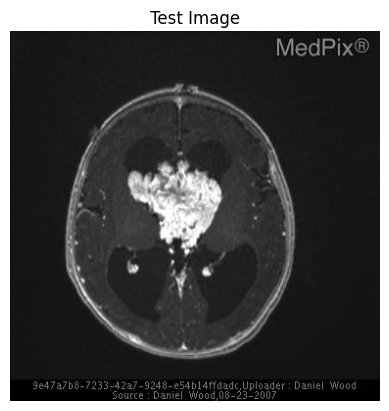

🧠 Random Test Example: 266
❓ Question: is the lesion hyperdense?
💬 Model Answer: 


In [19]:
import random, torch, matplotlib.pyplot as plt

model.eval()
tokenizer.pad_token = tokenizer.eos_token

# pick a random test example
idx = random.randint(0, len(dataset["test"]) - 1)
example = dataset["test"][idx]
image = example["image"].convert("RGB")
question = example["question"]

# encode
inputs = tokenizer(f"Q: {question}\nA:", return_tensors="pt")
pixel_values = vision_processor(images=image, return_tensors="pt")["pixel_values"]

# generate
with torch.no_grad():
    vision_out = model.vision_model(pixel_values)
    image_embeds = model.projection(vision_out.last_hidden_state.mean(dim=1)).unsqueeze(1)
    inputs_embeds = torch.cat(
        [image_embeds, model.language_model.get_input_embeddings()(inputs["input_ids"])],
        dim=1
    )
    generated_ids = model.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=torch.ones(inputs_embeds.shape[:2], dtype=torch.long),
        max_length=100,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        temperature=0.8,
        top_p=0.9
    )

answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# visualize and print
plt.imshow(image)
plt.axis("off")
plt.title("Test Image")
plt.show()

print(f"🧠 Random Test Example: {idx}")
print(f"❓ Question: {question}")
print(f"💬 Model Answer: {answer.strip()}")
